# Data description & Problem statement: 
This data set contains a total 5820 evaluation scores provided by students from Gazi University in Ankara (Turkey). There is a total of 28 course specific questions and additional 5 attributes. Please check the description at: http://archive.ics.uci.edu/ml/datasets/turkiye+student+evaluation

* Dataset is imbalanced. The data has 5820 rows and 33 variables.
* This is a classification problem. The classification goal is to predict number of times the student is taking this course: 0 (passed) and >0 (failed).

# Workflow:
- Load the dataset, and define the required functions (e.g. for detecting the outliers)
- Data Cleaning/Wrangling: Manipulate outliers, missing data or duplicate values, Encode categorical variables, etc. 
- Split data into training & test parts (utilize the training part for training and test part for the final evaluation of model)
   #  Model Training:
- Train an ensemble of Deep Neural Network models by Keras/Tensorflow, and finally aggregate the results (Note: I've utilized SMOTE technique via imblearn toolbox to synthetically over-sample the minority category and even the dataset imbalances.)
   # Model Evaluation: 
- Evaluate the Neural Network model on Test Dataset, by calculating:
     - AUC score
     - Confusion matrix
     - ROC curve  
     - Precision-Recall curve 
     - Average precision

In [1]:
import keras
import sklearn
import tensorflow as tf
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import random as rn
%matplotlib inline

import os
os.environ['PYTHONHASHSEED'] = '0'

# for the reproducable results:
np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
df=pd.read_csv('C:/Users/rhash/Documents/Datasets/wine quality/winequality-red.csv', sep=';') 

df['quality']=df['quality'].map({3:'L', 4:'L', 5:'L', 6:'L', 7:'H', 8:'H'})
df['quality']=df['quality'].map({'L':0,  'H':1})

In [3]:
# To Shuffle the data:
np.random.seed(42)
df=df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

df.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.7,0.56,0.08,2.50,0.114,14.0,46.0,0.9971,3.24,0.66,9.6,0
1,7.8,0.50,0.17,1.60,0.082,21.0,102.0,0.9960,3.39,0.48,9.5,0
2,10.7,0.67,0.22,2.70,0.107,17.0,34.0,1.0004,3.28,0.98,9.9,0
3,8.5,0.46,0.31,2.25,0.078,32.0,58.0,0.9980,3.33,0.54,9.8,0
4,6.7,0.46,0.24,1.70,0.077,18.0,34.0,0.9948,3.39,0.60,10.6,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [5]:
# Removes outliers (all rows) by one of Z-score, MAD or IQR-based approaches: 
def remove_outliers(df, name, thresh=3, method="Z_Score"):
    L=[]
    for name in name:
        
        if method=="Z_Score":
            drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (thresh * df[name].std()))]
              
        elif method=="MAD":
            median = np.median(df[name], axis=0)
            mad = np.median(np.abs(df[name] - median), axis=0)
            modified_z_score = 0.6745 * (df[name]-median) / mad
            drop_rows = df.index[modified_z_score >= 3.5]

        elif method=="IQR":
            quartile_1, quartile_3 = np.percentile(df[name], [25, 75])
            iqr = np.abs(quartile_3 - quartile_1)
            lower_bound = quartile_1 - (iqr * 1.5)
            upper_bound = quartile_3 + (iqr * 1.5)
            drop_rows = df.index[(df[name] > upper_bound) | (df[name] < lower_bound)]
        
        L.extend(list(drop_rows))
        
    df.drop(np.array(list(set(L))), axis=0, inplace=True)
    
remove_outliers(df, ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
      'pH', 'sulphates', 'alcohol'], thresh=9)

In [6]:
X=df[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']]
y=df['quality']

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scalor_X=MinMaxScaler().fit(X)
X=scalor_X.transform(X)

In [8]:
# we build a hold_out dataset for the final validation:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Resampling:
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

#X_r, y_r = SMOTE().fit_sample(X_train, y_train)
X_r, y_r = RandomOverSampler(random_state=0).fit_sample(X_train, y_train)

from keras.utils import to_categorical
y_r=to_categorical(y_r)
y_test=to_categorical(y_test)

In [9]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, f1_score

class EarlyStopByAUC(keras.callbacks.Callback):
    def __init__(self, value = 0, verbose = 0):
        super(keras.callbacks.Callback, self).__init__()
        self.value = value
        self.verbose = verbose


    def on_epoch_end(self, epoch, logs={}):
        #score = f1_score(np.argmax(self.validation_data[1], axis=1), np.argmax(model.predict(self.validation_data[0]), axis=1))
        score=roc_auc_score(self.validation_data[1], model.predict_proba(self.validation_data[0]))
        L.append(score)
        
        if score >= self.value:
            if self.verbose >0:
                print("Epoch %05d: early stopping Threshold" % epoch)
            self.model.stop_training = True

In [22]:
# KNN with Cross-Validation:
from sklearn.metrics import roc_auc_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2, l1
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_sample_weight
  
np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)
    
model = Sequential()
model.add(Dense(300, input_dim=X.shape[1], activation='relu', kernel_initializer = 'uniform', 
                                                                activity_regularizer=l2(0.001))) # Hidden 1
model.add(Dropout(0.2))
    
model.add(Dense(400, activation='relu', kernel_initializer = 'uniform', 
                                                          activity_regularizer=l2(0.001))) # Hidden 2
model.add(Dropout(0.2))
model.add(Dense(y_r.shape[1], activation='softmax', kernel_initializer='uniform')) # Output

L=[]
model.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopByAUC(value =0.95, verbose =1) #EarlyStopping(monitor='loss', min_delta=0.001, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model
    
history=model.fit(X_r,y_r, epochs=100, batch_size=16, validation_data=(X_test, y_test), callbacks=[monitor, checkpointer], verbose=0)
model.load_weights('best_weights.hdf5')

# Measure this fold's accuracy
auc_test=roc_auc_score(y_test, model.predict_proba(X_test))
auc_train=roc_auc_score(to_categorical(y_train), model.predict_proba(X_train))

print('Training auc score: ', auc_train, "\n")
print('Validation auc score: ', auc_test)

Epoch 00044: early stopping Threshold
Training auc score:  0.9620146163476251 

Validation auc score:  0.953951414514145


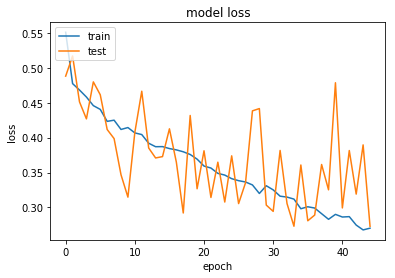

In [23]:
# list all data in history
#print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Confusion matrix, without normalization
[[233  38]
 [  3  45]]
Normalized confusion matrix
[[0.86 0.14]
 [0.06 0.94]]


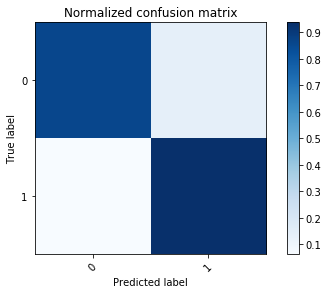

In [24]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names=["0", "1"]
    
# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

In [25]:
# Classification report:
report=classification_report(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))
print(report)

             precision    recall  f1-score   support

          0       0.99      0.86      0.92       271
          1       0.54      0.94      0.69        48

avg / total       0.92      0.87      0.88       319



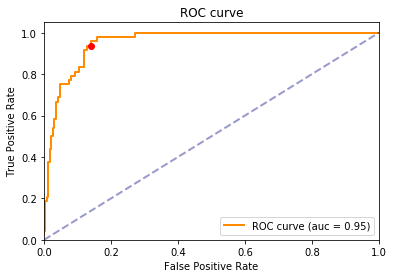

In [26]:
# ROC curve & auc:
from  sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score

fpr, tpr, thresholds=roc_curve(np.array(y_test[:, 1]), model.predict_proba(X_test)[:, 1] , pos_label=1)
roc_auc=roc_auc_score(np.array(y_test), model.predict_proba(X_test))

plt.figure()

plt.step(fpr, tpr, color='darkorange', lw=2, label='ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', alpha=0.4, lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

plt.plot([cm_normalized[0,1]], [cm_normalized[1,1]], 'or')
plt.show()

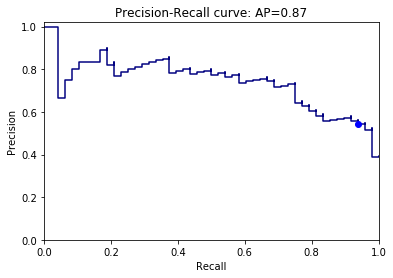

In [27]:
# Precision-Recall trade-off:
precision, recall, thresholds=precision_recall_curve(y_test[:, 1], model.predict_proba(X_test)[:, 1],  pos_label=1)
ave_precision=average_precision_score(y_test, model.predict_proba(X_test))

plt.step(recall, precision, color='navy')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0, 1.001])
plt.ylim([0, 1.02])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(ave_precision))

plt.plot([cm_normalized[1,1]], [cm[1,1]/(cm[1,1]+cm[0,1])], 'ob')
plt.show()